In [43]:
import os

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
import datetime as dt
import math

In [44]:
# User input
# Version number
v = 3  # For file naming

# Filepath to baseline daily river data
fpath_baseline_data = r"/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/martini_rivers_v9_1990_2022_stage1data.nc"

# Baseline for SPM
spm_bsl_fpath = r"/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/river_scenarios/of800_v10ad_forcing_files/of800_rivers_v9_2017_2019_SPM.nc"

# Filepath to river metadata csvs
real_riv_metadata = r"../data/real_river_metadata.csv"

# TEOTIL results (annual source apportionment)
# Baseline and scenario data
teotil_res_csv_fpath = (
    r"/home/jovyan/shared/common/oslofjord_modelling/phase3_scenarios/teotil3_oslomod_results_2017-2019.csv"
)

# Start and end year to summarise TEOTIL data over (inclusive??)
start_year = 2017
end_year = 2019

# Folders for output files
summary_csv_folder = r"/home/jovyan/shared/common/oslofjord_modelling/phase3_scenarios/summary_csvs"
fig_folder = r"../output/plots/v3"

# REAL river numbers to use
# full OF800 domain: model rivs 5-29 incl. Drop Sweden, becomes 7 to 29 (incl.). Real rivs 4 to 23.
# (v3: scenarios generated for vassdragsområder 001 (real riv 6-Tista, model riv 7) to 017 (real riv 23-Kammerfosselva, model riv 29), i.e. full OF800 domain excl. sweden)
oslofjord_riv_nos = range(6, 24)  # Whole OF domain, excluding 2 Swedish rivers

# For SPM, also need model river numbers to include
# v2: River input scenario generated for model rivs 7-29 (incl.), but summarise over
# the full OF800 domain (model rivers 5 to 29, inclusive, i.e. include Sweden)
oslofjord_model_riv_nos = list(range(5, 30))  # Model river numbers

# Species to alter in the scenarios (teotil3 species; mapping to of800 species done below)
# choose from ['din', 'tdp', 'ss', 'toc', 'ton', 'totn', 'totp', 'tpp']
t3_par_list = ['din', 'tdp', 'toc', 'ton', 'totn', 'totp', 'tpp', 'ss']

In [45]:
# Dictionary to map from TEOTIL3 variable name to OF800 variable names
# We assume the same % reduction across all of800 variable names returned for a given
# TEOTIL3 variable name
# N.B. river_TIP is not used downstream in OF800, so do not include in the mapping.
var_mapping_teotil3_to_of800 = {
    'din': ['river_NH4N', 'river_NO3NO2N'],
    'ton': ['river_DON', 'river_PON'],
    'totn': ['river_TOTN'],
    'totp': ['river_TOTP'],
    'tdp': ['river_SRP', 'river_DOP'],
    'tpp': ['river_POP'],  # PIP isn't used in Martini, so don't worry about
    'toc': ['river_TOC'],
    #'ss': ['river_SPM']#  # SPM is in a separate netcdf file. Just provide Phil with factors
}

# Calculate start date (inclusive), end date (day after last day)
start_date = dt.datetime(start_year, 1, 1)
end_date = dt.datetime(end_year, 12, 31)
end_date += pd.Timedelta(days=1)

# River chemistry metadata
river_meta_df = pd.read_csv(real_riv_metadata, index_col=0, dtype={'Vassom':str})
# Limit to just Oslofjord rivers
river_meta_df = river_meta_df[river_meta_df.index.isin(oslofjord_riv_nos)]
# Add 'total' row for use later
river_meta_df.loc['Total', ['river_name', 'Regine', 'Regine_to_sea', 'Vassom']] = 'Total'
river_meta_df.query('real_river in @oslofjord_riv_nos')

,river_name,Outflow_lat,Outflow_lon,Regine,Regine_to_sea,Vassom,Vassom_area_land,Vassom_area_tot,Andre_MCA_area,Andre_area_q,Overestimate (%),Comment
real_river,,,,,,,,,,,,
6.0,Tista,59.119,11.370,001.A1,001.A1,001.,2495.0,2507.0,2507.0,1584.0,0.0,NaN
7.0,Glomma,59.206,10.953,002.A51,002.A11,002.,42446.0,43116.0,43116.0,41967.0,2.0,Monitoring point upstream of Sarpsborg RA. So ...
8.0,Mosseelva,59.439,10.662,003.A1,003.A1,003.,854.0,1052.0,1054.0,694.0,23.0,NaN
9.0,Hølenelva,59.523,10.690,004.A0,004.A0,004.,204.0,227.0,NaN,NaN,11.0,NaN
10.0,Årungen,59.720,10.728,005.3A,005.3A,005.,280.0,368.0,144.0,85.0,31.0,NaN
11.0,Akerselva,59.908,10.756,006.A10,006.A10,006.,392.0,415.0,415.0,307.0,6.0,NaN
12.0,Lysakerelva,59.914,10.640,007.A0,007.A0,007.,202.0,211.0,211.0,177.0,4.0,NaN
13.0,Sandvikselva,59.890,10.523,008.A11,008.A11,008.,279.0,311.0,311.0,226.0,11.0,NaN
14.0,Åros,59.704,10.519,009.A0,009.A0,009.,215.0,253.0,NaN,NaN,18.0,NaN


# Read in TEOTIL3 data

In [46]:
def extract_source(col_name):
    """
    Function to rename teotil columns
    """
    parts = col_name.split('_')
    return parts[1]


def read_teotil_data(teotil_data_fpath, par):
    """
    Function to read raw TEOTIL data, pick the columns of interest (just accumulated inputs
    from all upstream areas), rename columns, truncate to the period of interest.

    Do this for areas upstream of a given regine of interest
    """
    df = pd.read_csv(teotil_data_fpath)

    # Just pick out accumulated inputs (from all upstream areas) for the outflow reginer of interest
    # Also just pick columns for the single parameter of interest
    cols = ["scenario", "regine", "year"] + [
        col for col in df.columns if f"_{par}_" in col and col.startswith("accum")
    ]
    df = df.loc[df['regine'].isin(river_meta_df['Regine'])][cols]

    # Truncate to start of model period
    df = df.loc[df['year'] >= start_year]
    df = df.loc[df['year'] <= end_year]

    # Replace 'regine' index with river numbers, for easier matching to the river data
    mapping_dict = river_meta_df.reset_index().set_index('Regine')['real_river'].to_dict()
    df.index = df['regine'].map(mapping_dict)
    df.index.name = 'real_river'
    df = df.drop('regine', axis=1)

    # Rename columns
    cols_to_exclude = ['scenario', 'year']
    new_col_names_dict = {col: extract_source(col) for col in df.columns if col not in cols_to_exclude}
    new_col_names = cols_to_exclude + list(new_col_names_dict.values())
    col_dict = dict(zip(df.columns, new_col_names))
    df = df.rename(columns=col_dict)

    return df


def teotil_average_over_years(df):
    """
    Average over all years to get a single value per main catchment area (or real river).
    Replace 'regine' index with river numbers
    """

    # Average over the year column per regine
    group_col = df.index.name
    av_df = df.reset_index().groupby(group_col).mean().drop('year', axis=1)

    return av_df

In [47]:
teotil_res_csv_fpath = (
    r"/home/jovyan/shared/common/oslofjord_modelling/phase3_scenarios/teotil3_oslomod_results_2017-2019.csv"
)

t3_raw_df = pd.read_csv(teotil_res_csv_fpath)

# Just keep baseline
t3_raw_df = t3_raw_df.loc[t3_raw_df['scenario'] == 'Baseline']

# Truncate to start of model period
t3_raw_df = t3_raw_df.loc[t3_raw_df['year'] >= start_year]
t3_raw_df = t3_raw_df.loc[t3_raw_df['year'] <= end_year]

# Just pick out regines of interest
t3_raw_df = t3_raw_df.loc[t3_raw_df['regine'].isin(river_meta_df['Regine'])]

t3_raw_df.head()

,scenario,year,regine,regine_down,accum_agriculture-background_din_kg,accum_agriculture-background_ss_kg,accum_agriculture-background_tdp_kg,accum_agriculture-background_toc_kg,accum_agriculture-background_ton_kg,accum_agriculture-background_totn_kg,...,local_urban_totp_kg,local_urban_tpp_kg,local_wood_din_kg,local_wood_ss_kg,local_wood_tdp_kg,local_wood_toc_kg,local_wood_ton_kg,local_wood_totn_kg,local_wood_totp_kg,local_wood_tpp_kg
500,Baseline,2017,010.2Z,010.,52.180448,8.895904,0.121095,1096.694626,22.911032,75.091480,...,41.0,16.4,768.1,16187.2,15.4,129497.7,2556.8,3324.9,89.1,73.7
1266,Baseline,2017,005.3A,005.,4425.603145,8712.743750,10.138704,99632.696719,1446.255505,5871.858651,...,3.7,1.5,42.4,899.0,0.9,7551.8,145.7,188.1,5.3,4.4
1722,Baseline,2017,004.A0,004.,12805.881027,210946.692079,21.401722,338488.818597,3227.216003,16033.097029,...,257.5,103.0,1152.7,25140.6,23.9,217466.1,4228.6,5381.3,143.3,119.4
2027,Baseline,2017,010.3A,010.,890.186477,5738.664830,2.272592,29339.829204,303.117658,1193.304135,...,16.9,6.8,237.3,5000.4,4.8,40003.4,790.1,1027.4,27.3,22.5
2095,Baseline,2017,013.A0,013.,8155.038273,111514.299132,17.593045,177129.066299,2189.551471,10344.589744,...,40.3,16.1,46.0,955.4,1.0,6878.6,139.8,185.8,4.9,3.9


## Get upstream area per hovedelv and work out area scaling factors to apply to of800 inputs

OF800 inputs include discharge for the whole vassdragsområde, including sea areas. So to back-calculate to the discharge just in the hovedelv, we need to multiply the loads (or the discharge) by the area upstream of the hovedelv regine / the whole vasssdragsområde area. Work out that scaling here.

In [48]:
# Just pick one year
area_df = t3_raw_df.loc[t3_raw_df['year'] == 2018].copy()

# Add real river number
mapping_dict = river_meta_df.reset_index().set_index('Regine')['real_river'].to_dict()
area_df['real_river'] = area_df['regine'].map(mapping_dict)

cols_to_keep = ['real_river', 'regine', 'accum_upstr_area_km2']
area_df = area_df[cols_to_keep]
area_df = area_df.set_index('real_river')

area_df.head()

,regine,accum_upstr_area_km2
real_river,,
15.0,010.2Z,17.938556
10.0,005.3A,51.870026
9.0,004.A0,139.018794
16.0,010.3A,34.748094
19.0,013.A0,197.027460


In [49]:
# Add regine upstream area to the metadata file
mapping = area_df.set_index('regine')['accum_upstr_area_km2']
river_meta_df['reg_upstr_area_km2'] = river_meta_df['Regine'].map(mapping).round(2)

# Calculate area scaling factor, for scaling of800 inputs to match TEOTIL3 for areas upstream of the regine
# i.e. multiply of800 flux by reg_area_scaling_f to make it compatible with TEOTIL3 estimates for the hovedelv regine
river_meta_df['reg_area_scaling_f'] = river_meta_df['reg_upstr_area_km2'] / river_meta_df['Vassom_area_tot']

river_meta_df

,river_name,Outflow_lat,Outflow_lon,Regine,Regine_to_sea,Vassom,Vassom_area_land,Vassom_area_tot,Andre_MCA_area,Andre_area_q,Overestimate (%),Comment,reg_upstr_area_km2,reg_area_scaling_f
real_river,,,,,,,,,,,,,,
6.0,Tista,59.119,11.370,001.A1,001.A1,001.,2495.0,2507.0,2507.0,1584.0,0.0,NaN,1583.50,0.631631
7.0,Glomma,59.206,10.953,002.A51,002.A11,002.,42446.0,43116.0,43116.0,41967.0,2.0,Monitoring point upstream of Sarpsborg RA. So ...,41746.14,0.968228
8.0,Mosseelva,59.439,10.662,003.A1,003.A1,003.,854.0,1052.0,1054.0,694.0,23.0,NaN,693.43,0.659154
9.0,Hølenelva,59.523,10.690,004.A0,004.A0,004.,204.0,227.0,NaN,NaN,11.0,NaN,139.02,0.612423
10.0,Årungen,59.720,10.728,005.3A,005.3A,005.,280.0,368.0,144.0,85.0,31.0,NaN,51.87,0.140951
11.0,Akerselva,59.908,10.756,006.A10,006.A10,006.,392.0,415.0,415.0,307.0,6.0,NaN,237.70,0.572771
12.0,Lysakerelva,59.914,10.640,007.A0,007.A0,007.,202.0,211.0,211.0,177.0,4.0,NaN,176.63,0.837109
13.0,Sandvikselva,59.890,10.523,008.A11,008.A11,008.,279.0,311.0,311.0,226.0,11.0,NaN,225.86,0.726238
14.0,Åros,59.704,10.519,009.A0,009.A0,009.,215.0,253.0,NaN,NaN,18.0,NaN,113.79,0.449763


## Extract and average TEOTIl3 data of interest

In [50]:
# Drop strings and years, ready to just group the 3 years by reginer
t3_av_df = t3_raw_df.drop(['scenario', 'regine_down', 'year'], axis=1)

# Average over the year column per regine
t3_av_df = t3_av_df.groupby('regine').mean()

# # Add real river number, drop regine, and reset index
mapping_dict = river_meta_df.reset_index().set_index('Regine')['real_river'].to_dict()
t3_av_df['real_river'] = t3_av_df.index.map(mapping_dict)
t3_av_df = t3_av_df.set_index('real_river')

t3_av_df

,accum_agriculture-background_din_kg,accum_agriculture-background_ss_kg,accum_agriculture-background_tdp_kg,accum_agriculture-background_toc_kg,accum_agriculture-background_ton_kg,accum_agriculture-background_totn_kg,accum_agriculture-background_totp_kg,accum_agriculture-background_tpp_kg,accum_agriculture_din_kg,accum_agriculture_ss_kg,...,local_urban_totp_kg,local_urban_tpp_kg,local_wood_din_kg,local_wood_ss_kg,local_wood_tdp_kg,local_wood_toc_kg,local_wood_ton_kg,local_wood_totn_kg,local_wood_totp_kg,local_wood_tpp_kg
real_river,,,,,,,,,,,,,,,,,,,,,
6.0,25952.762029,2.626940e+04,46.234456,5.134996e+05,9676.962968,35629.724996,100.001465,53.767010,2.335749e+05,3.283042e+05,...,15.533333,6.200000,3.666667,92.733333,0.100000,996.866667,18.833333,22.500000,0.600000,0.500000
7.0,666280.612227,3.782000e+06,1084.965189,1.158992e+07,194296.475505,860577.087732,6682.089345,5597.124156,5.996526e+06,1.396420e+08,...,421.266667,168.500000,236.233333,5733.233333,4.600000,57619.000000,1099.633333,1335.866667,34.133333,29.533333
8.0,19159.413541,2.551687e+04,42.256370,5.355960e+05,6953.432317,26112.845858,128.883998,86.627628,1.724347e+05,5.029977e+05,...,9.866667,3.933333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9.0,15678.249818,2.582616e+05,21.401722,3.905840e+05,3949.269782,19627.519599,401.921597,380.519875,1.411042e+05,6.620954e+06,...,296.966667,118.800000,1329.466667,28996.266667,27.566667,250817.666667,4877.166667,6206.633333,165.300000,137.733333
10.0,5735.416471,1.282295e+04,10.138704,1.306102e+05,1875.724307,7611.140779,45.658055,35.519351,5.161875e+04,2.678903e+05,...,4.866667,1.933333,55.533333,1176.600000,1.133333,9883.466667,190.700000,246.233333,6.833333,5.700000
11.0,715.638420,3.781614e+03,1.471937,2.015419e+04,227.199131,942.837551,10.086502,8.614565,6.440746e+03,3.790525e+04,...,1.100000,0.433333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12.0,1334.448489,1.497922e+04,2.425818,3.236897e+04,400.917323,1735.365811,22.669805,20.243987,1.201004e+04,2.661541e+05,...,841.266667,336.500000,2119.600000,42181.366667,42.200000,320578.333333,6152.166667,8271.766667,244.666667,202.466667
13.0,3699.560426,5.455660e+04,7.579858,8.540875e+04,1013.777871,4713.338297,87.024224,79.444366,3.329604e+04,1.003082e+06,...,3.800000,1.533333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14.0,5188.694452,6.777533e+04,10.854795,1.098501e+05,1449.110005,6637.804457,91.348903,80.494107,4.669825e+04,3.909495e+06,...,346.766667,138.700000,1335.966667,27659.933333,27.666667,210215.500000,4155.900000,5491.866667,150.766667,123.100000


In [51]:
def extract_source(col_name):
    """
    Function to rename teotil columns
    """
    parts = col_name.split('_')
    return parts[1]


# Extract just the accumulated upstream inputs and then sum over them per variable
t3_s_li = []
for par in t3_par_list:
    # Also pick columns for the single parameter of interest
    cols = [
        col for col in t3_av_df.columns if f"_{par}_" in col and col.startswith("accum")
    ]
    t3_var_df = t3_av_df[cols]

    t3_var_s = t3_var_df.sum(axis=1)
    t3_var_s.name = par
    t3_s_li.append(t3_var_s)

# Concatenate variables into a single df
t3_df = pd.concat(t3_s_li, axis=1)

# Convert to tonnes
t3_df = t3_df / 1000

t3_df.round(1)

,din,tdp,toc,ton,totn,totp,tpp,ss
real_river,,,,,,,,
6.0,371.4,8.1,5318.2,320.5,691.9,13.5,5.4,938.8
7.0,9543.5,122.7,99368.0,5942.5,15486.0,348.3,225.5,157717.8
8.0,235.3,4.6,3027.1,146.9,382.2,7.3,2.6,707.4
9.0,175.3,2.5,1187.7,57.6,232.9,14.2,11.7,7252.5
10.0,61.8,0.9,229.3,22.1,83.9,1.8,0.9,299.0
11.0,37.0,1.4,1181.3,40.8,77.8,2.5,1.1,627.9
12.0,33.8,1.0,1437.2,39.5,73.3,2.4,1.4,573.1
13.0,69.9,2.2,1453.7,47.8,117.7,5.3,3.1,1777.6
14.0,69.8,2.1,803.2,34.0,103.8,6.9,4.9,4295.6


# Read in OF800 data and calculate fluxes

In [52]:
bsl_ds = xr.open_dataset(fpath_baseline_data)
bsl_ds

<xarray.Dataset> Size: 38MB
Dimensions:                       (river_time: 12053, real_river: 39)
Coordinates:
  * real_river                    (real_river) float64 312B 1.0 2.0 ... 39.0
  * river_time                    (river_time) datetime64[ns] 96kB 1990-01-01...
Data variables: (12/22)
    river_ALK                     (river_time, real_river) float32 2MB ...
    river_DIC                     (river_time, real_river) float32 2MB ...
    river_DOC                     (river_time, real_river) float32 2MB ...
    river_DON                     (river_time, real_river) float32 2MB ...
    river_DOP                     (river_time, real_river) float32 2MB ...
    river_DSi                     (river_time, real_river) float32 2MB ...
    ...                            ...
    river_TSiO2                   (river_time, real_river) float32 2MB ...
    river_latitude_main_station   (real_river) float64 312B ...
    river_longitude_main_station  (real_river) float64 312B ...
    river_pH                      (river_time, real_river) float32 2MB ...
    river_temp                    (river_time, real_river) float32 2MB ...
    river_transport               (river_time, real_river) float32 2MB ...
Attributes:
    river_main_station_names_1-10:   1=Göta älv, Alelyckan; 2=Bäveån Uddevall...
    river_main_station_names_11-20:  11=Akerselva, hovedmålestasjon; 12=Lysak...
    river_main_station_names_21-30:  21=Numedalslågen ved Bommestad (E18); 22...
    river_main_station_names_31-39:  31=Kvina; 32=Klostergrøften, Klostergrøf...
    history:                         Thu Mar 21 17:07:47 2024: ncks -4 -L 5 m...
    NCO:                             4.7.2

**Note:** Units of DOC and TOC are mg/l, POC is ug/l. So can't add DOC and POC without converting units. 

In [53]:
# If present, drop 'ss' from t3_par_li
if 'ss' in t3_par_list:
    t3_par_li_no_ss = t3_par_list.copy()
    t3_par_li_no_ss.remove('ss')

# Make list of of800 chem variables to be updated (for slicing baseline netcdf)
of800_chem_var_li = []
for par in t3_par_li_no_ss:
    of800_chem_var_li.extend(var_mapping_teotil3_to_of800[par])

# Drop all the fractions apart from the teotil3 ones
keep_cols = of800_chem_var_li + ['river_transport']

bsl_ds = xr.open_dataset(fpath_baseline_data)

# Convert to dataframe for easier manipulation (by me!)
bsl_conc_df = bsl_ds.to_dataframe().loc[:, keep_cols]

# Convert all numeric columns to float64 (chem cols were float32)
bsl_conc_df[keep_cols] = bsl_conc_df[keep_cols].astype(float)

bsl_conc_df = bsl_conc_df.reset_index()  # Drop multiindex

# Select just the Oslofjord rivers
bsl_conc_df = bsl_conc_df[bsl_conc_df['real_river'].isin(oslofjord_riv_nos)]

# Truncate to start and end date
bsl_conc_df = bsl_conc_df.query('@start_date <= river_time <= @end_date')

# Drop time info and rename column 
bsl_conc_df['river_time'] = bsl_conc_df['river_time'].dt.normalize()
bsl_conc_df.rename(columns={'river_time': 'date'}, inplace=True)

bsl_conc_df

,date,real_river,river_NH4N,river_NO3NO2N,river_SRP,river_DOP,river_TOC,river_DON,river_PON,river_TOTN,river_TOTP,river_POP,river_transport
384623,2017-01-01,6.0,13.899307,590.861938,10.813172,15.786407,9.010278,350.626862,19.759489,975.327026,30.402235,3.802656,2.374053
384624,2017-01-01,7.0,28.220715,453.999664,5.344177,1.276579,4.247560,143.950867,30.723421,657.173706,11.878257,3.714239,413.006226
384625,2017-01-01,8.0,87.972572,522.602051,4.019380,12.168862,8.691258,326.141663,23.971344,960.905334,19.109123,2.920881,7.138041
384626,2017-01-01,9.0,538.515137,4274.081543,40.727840,98.838448,8.691258,1336.557129,23.971344,6173.342773,142.487167,2.920881,1.554746
384627,2017-01-01,10.0,159.264008,2376.056396,15.283289,22.282393,7.056539,1359.362061,18.862183,3913.715820,40.322411,2.258925,0.426817
...,...,...,...,...,...,...,...,...,...,...,...,...,...
427302,2019-12-31,19.0,17.880396,641.613220,22.077616,3.087059,6.650886,153.409073,17.634790,830.697632,27.266380,2.101705,6.795247
427303,2019-12-31,20.0,210.453171,1744.519653,21.585827,5.090003,6.206216,0.000000,15.322986,1970.295898,41.346577,1.927450,39.966537
427304,2019-12-31,21.0,39.965130,208.524704,2.946716,1.540593,4.396276,143.308258,15.844756,407.786743,7.328516,2.841206,148.840500
427305,2019-12-31,22.0,8.145335,158.108063,1.807409,0.994220,2.800433,133.921066,14.229559,314.533264,4.539244,1.737616,253.448303


In [54]:
bsl_conc_df['real_river'].unique()

array([ 6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18.,
       19., 20., 21., 22., 23.])

In [55]:
# Sum across columns to translate from Of800 to t3 vars

# List of teotil3 variables of interest for all except SS
t3_vars = list(var_mapping_teotil3_to_of800.keys())

# Calculate TEOTIL3 variables from OF800 variables
for t3_var in t3_vars:
    bsl_conc_df[t3_var] = bsl_conc_df[var_mapping_teotil3_to_of800[t3_var]].sum(axis=1)

# Drop all the fractions apart from the teotil3 ones
keep_cols = ['real_river', 'date', 'river_transport'] + t3_vars
bsl_conc_df = bsl_conc_df[keep_cols]

# Convert all conc units to mg/l
# (currently only TOC is mg/l, rest are ug/l)
ugL_list = ['din', 'ton', 'totn', 'totp', 'tdp', 'tpp']
bsl_conc_df[ugL_list] = bsl_conc_df[ugL_list] * 0.001

bsl_conc_df

/tmp/ipykernel_2006/2382563178.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsl_conc_df[ugL_list] = bsl_conc_df[ugL_list] * 0.001


,real_river,date,river_transport,din,ton,totn,totp,tdp,tpp,toc
384623,6.0,2017-01-01,2.374053,0.604761,0.370386,0.975327,0.030402,0.026600,0.003803,9.010278
384624,7.0,2017-01-01,413.006226,0.482220,0.174674,0.657174,0.011878,0.006621,0.003714,4.247560
384625,8.0,2017-01-01,7.138041,0.610575,0.350113,0.960905,0.019109,0.016188,0.002921,8.691258
384626,9.0,2017-01-01,1.554746,4.812597,1.360528,6.173343,0.142487,0.139566,0.002921,8.691258
384627,10.0,2017-01-01,0.426817,2.535320,1.378224,3.913716,0.040322,0.037566,0.002259,7.056539
...,...,...,...,...,...,...,...,...,...,...
427302,19.0,2019-12-31,6.795247,0.659494,0.171044,0.830698,0.027266,0.025165,0.002102,6.650886
427303,20.0,2019-12-31,39.966537,1.954973,0.015323,1.970296,0.041347,0.026676,0.001927,6.206216
427304,21.0,2019-12-31,148.840500,0.248490,0.159153,0.407787,0.007329,0.004487,0.002841,4.396276
427305,22.0,2019-12-31,253.448303,0.166253,0.148151,0.314533,0.004539,0.002802,0.001738,2.800433


## Read in SPM data

In [56]:
def riv_ds_to_df(nc_fpath, oslofjord_model_riv_nos, species_dict):
    """
    Read in OF800 river input netcdf file. Convert to dataframe of concentrations (mg N, P or C/l)
    & river discharge (m3/s) for real rivers. Output dataframe.
    """

    # Make list of variables to save from the ds
    # To do this, flatten all variable lists in species_dict into a single list, then remove duplicates
    riv_var_li = list(set(var for sublist in species_dict.values() for var in sublist))
    riv_var_li = riv_var_li + ['river_transport']

    # List of teotil3 variables
    t3_vars = list(species_dict.keys())

    # Start processing
    ds = xr.open_dataset(nc_fpath)

    # Check whether all vars in riv_var_li are present in the ds
    # (won't be, as have SPM processing separate to nutrient processing)
    missing_vars = [var for var in riv_var_li if var not in ds.variables]
    if missing_vars:
        print(f"Warning: The following variables are not found in the dataset and will be excluded: {missing_vars}")

    # Filter to only include present variables
    present_vars = [var for var in riv_var_li if var in ds.variables]
    ds = ds[present_vars]

    df = ds.to_dataframe()
    ds.close()
    df = df.reset_index()  # Drop multiindex

    # Remove depth info
    if 's_rho' in df.columns:
        df = df.drop(columns=['s_rho'])
        df = df.drop_duplicates()  # There were around 40 s_rho values for each (river_time, river)

    df = df.sort_values(by=['river', 'river_time'])

    # Take the absolute of discharge values (assume they give direction)
    df['river_transport'] = df['river_transport'].abs()

    # Select just model river numbers of interest
    df = df[df['river'].isin(oslofjord_model_riv_nos)].copy()

    # Add real river number & drop the model number
    df['real_river'] = df['river'].map(river_nos_s)
    df = df.drop(columns=['river'])

    # Truncate to time period of interest
    df['year'] = df['river_time'].dt.year
    df = df.loc[(df['year'] >= start_year) & (df['year'] <= end_year)]
    df = df.drop('year', axis=1)

    # Calculate TEOTIL3 variables from OF800 variables
    for t3_var in t3_vars:
        df[t3_var] = df[species_dict[t3_var]].sum(axis=1)

    # Drop all the fractions apart from the teotil3 ones
    keep_cols = t3_vars + ['real_river', 'river_time', 'river_transport']
    df = df[keep_cols]

    to_float64_vars = ['river_transport'] + t3_vars
    # SPM data was stored as float 32. Convert all to float 64
    df[to_float64_vars] = df[to_float64_vars].astype('float64')

    # Sum or average over model rivers to get real river data

    # groupby object used multiple times below
    grouped = df.groupby(['real_river', 'river_time'])

    # Sum discharge
    sum_df = grouped.agg({'river_transport': 'sum'})

    # Mean of the chem columns within each river
    mean_df = grouped[t3_vars].mean()

    # Join the sums and means to one df
    conc_df = pd.concat([sum_df, mean_df], axis=1)
    conc_df = conc_df.reset_index()

    # Rename cols
    rename_dict = {'river_time': 'date', 'river_transport': 'Q'}
    conc_df = conc_df.rename(rename_dict, axis=1)

    return conc_df


# Mapping from model river number to real river number (index: model riv no, returns real no)
setup_fpath = r"../data/oslofjord_location_ids.csv"
river_nos_s = pd.read_csv(setup_fpath, index_col=0).squeeze('columns')

# Dictionary for renamning SPM
ss_dict = {"ss": ["river_SPM"]}

ss_conc_df = riv_ds_to_df(spm_bsl_fpath, oslofjord_model_riv_nos, ss_dict)

# Drop time info and rename column 
ss_conc_df['date'] = ss_conc_df['date'].dt.normalize()

ss_conc_df.head()

,real_river,date,Q,ss
0,4,2017-01-01,0.373,1.662604
1,4,2017-01-02,0.306,1.663058
2,4,2017-01-03,0.293,1.663514
3,4,2017-01-04,0.278,1.663971
4,4,2017-01-05,0.211,1.664430


In [57]:
ss_conc_df['real_river'].unique()

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21,
       22, 23])

## Join nutrient and SPM concentration data

In [58]:
of_conc_df = pd.merge(bsl_conc_df, ss_conc_df, on=['real_river', 'date'], how='left')
# Q from SPM df is the same as from the conc df (checked and good), so drop
of_conc_df = of_conc_df.drop('Q', axis=1)
print(of_conc_df['real_river'].unique())
of_conc_df

[ 6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23.]


,real_river,date,river_transport,din,ton,totn,totp,tdp,tpp,toc,ss
0,6.0,2017-01-01,2.374053,0.604761,0.370386,0.975327,0.030402,0.026600,0.003803,9.010278,5.624686
1,7.0,2017-01-01,413.006226,0.482220,0.174674,0.657174,0.011878,0.006621,0.003714,4.247560,6.152798
2,8.0,2017-01-01,7.138041,0.610575,0.350113,0.960905,0.019109,0.016188,0.002921,8.691258,1.857670
3,9.0,2017-01-01,1.554746,4.812597,1.360528,6.173343,0.142487,0.139566,0.002921,8.691258,119.402542
4,10.0,2017-01-01,0.426817,2.535320,1.378224,3.913716,0.040322,0.037566,0.002259,7.056539,6.031871
...,...,...,...,...,...,...,...,...,...,...,...
19705,19.0,2019-12-31,6.795247,0.659494,0.171044,0.830698,0.027266,0.025165,0.002102,6.650886,10.349716
19706,20.0,2019-12-31,39.966537,1.954973,0.015323,1.970296,0.041347,0.026676,0.001927,6.206216,17.379465
19707,21.0,2019-12-31,148.840500,0.248490,0.159153,0.407787,0.007329,0.004487,0.002841,4.396276,2.999231
19708,22.0,2019-12-31,253.448303,0.166253,0.148151,0.314533,0.004539,0.002802,0.001738,2.800433,0.744690


## Calculate daily and annual fluxes

In [59]:
def calc_daily_flux(conc_df, t3_vars, q_col):
    """
    Units kg/day
    Assumes units in conc_df are mg/l and Q is in m3/s
    """
    load_df = conc_df[['real_river', 'date']].copy()

    # Ensure the 'date' column is in datetime format
    load_df['date'] = pd.to_datetime(load_df['date'])
    load_df[q_col] = conc_df[q_col] * 86400  # from m3/s to m3/day

    for var in t3_vars:
        # Load in kg/day
        chem_kgperm3 = conc_df[var] * 1000 * 10**-6
        load_df[var] = load_df[q_col] * chem_kgperm3

    return load_df


t3_vars = t3_vars + ['ss']

daily_load_df = calc_daily_flux(of_conc_df, t3_vars, 'river_transport')
# Rename Q column
daily_load_df = daily_load_df.rename({'river_transport': 'Q'}, axis=1)
daily_load_df.round(0)

,real_river,date,Q,din,ton,totn,totp,tdp,tpp,toc,ss
0,6.0,2017-01-01,205118.0,124.0,76.0,200.0,6.0,5.0,1.0,1848.0,1154.0
1,7.0,2017-01-01,35683738.0,17207.0,6233.0,23450.0,424.0,236.0,133.0,151569.0,219555.0
2,8.0,2017-01-01,616727.0,377.0,216.0,593.0,12.0,10.0,2.0,5360.0,1146.0
3,9.0,2017-01-01,134330.0,646.0,183.0,829.0,19.0,19.0,0.0,1167.0,16039.0
4,10.0,2017-01-01,36877.0,93.0,51.0,144.0,1.0,1.0,0.0,260.0,222.0
...,...,...,...,...,...,...,...,...,...,...,...
19705,19.0,2019-12-31,587109.0,387.0,100.0,488.0,16.0,15.0,1.0,3905.0,6076.0
19706,20.0,2019-12-31,3453109.0,6751.0,53.0,6804.0,143.0,92.0,7.0,21431.0,60013.0
19707,21.0,2019-12-31,12859819.0,3196.0,2047.0,5244.0,94.0,58.0,37.0,56535.0,38570.0
19708,22.0,2019-12-31,21897933.0,3641.0,3244.0,6888.0,99.0,61.0,38.0,61324.0,16307.0


In [60]:
def calc_month_annual_flux(daily_load_df, freq, t3_vars):
    """
    Input:
        freq: 'monthly' for monthly, 'annual' for annual
        run_type: string, for file naming. E.g. 'baseline'
    Output: df, units Q: 10^6 m3/month or year; chem cols: T/month or year
    """
    freq_dict = {'monthly': 'ME',
                 'annual': 'YE'}

    # daily_load_df.set_index(['real_river', 'date'], inplace=True)
    agg_load_df = daily_load_df.set_index(['real_river', 'date']).groupby('real_river').resample(freq_dict[freq], level='date').sum()
    agg_load_df.reset_index(inplace=True)

    # Convert units: chem species from kg to 10^3 kg/month (T/month)
    for var in t3_vars:
        agg_load_df[var] = agg_load_df[var] / 10**3

    # Convert Q from m3 to 10^6 m3
    agg_load_df['Q'] = agg_load_df['Q'] / 10**6

    if freq == 'annual':
        agg_load_df['year'] = pd.to_datetime(agg_load_df['date']).dt.year
        agg_load_df = agg_load_df.drop('date', axis=1)

    return agg_load_df


def mean_annual_flux(annual_load_df):
    """
    Average over years to get overall mean annual flux per real river
    Inputs run_type: format string, for filenaming
    Output: df, index: real_river, cols: Q (10^6 m3/yr), t3_vars (T/yr)
    """
    # Drop 'year'
    yr_mean_df = annual_load_df.drop('year', axis=1)
    yr_mean_df = yr_mean_df.groupby('real_river').mean()

    return yr_mean_df

In [61]:
# Calculate annual
of_yearly_df = calc_month_annual_flux(daily_load_df, 'annual', t3_vars)
# Average over years
of_yearly_df = mean_annual_flux(of_yearly_df)

# Drop discharge
of_yearly_df = of_yearly_df.drop('Q', axis=1)

of_yearly_df.round(1)

,din,ton,totn,totp,tdp,tpp,toc,ss
real_river,,,,,,,,
6.0,714.2,435.7,1150.2,32.7,28.8,3.7,10645.2,3447.0
7.0,9365.5,4767.8,14139.3,387.5,268.2,76.6,100649.1,170864.1
8.0,455.4,280.7,736.3,14.0,12.4,1.6,4817.0,1990.6
9.0,270.2,119.6,389.8,12.7,12.4,0.3,999.4,5073.6
10.0,142.6,87.1,229.7,3.1,3.0,0.1,386.8,623.5
11.0,42.6,36.8,79.4,2.6,2.4,0.2,835.8,1335.7
12.0,34.3,55.4,89.7,2.6,2.2,0.4,1227.8,1192.2
13.0,100.2,56.5,156.8,2.4,2.0,0.3,1050.2,656.9
14.0,483.6,258.0,741.7,19.7,18.8,0.9,2870.9,4822.0


##  Area-scale (hopefully back to original)

In [62]:
scaled_of_df = of_yearly_df.mul(river_meta_df['reg_area_scaling_f'], axis=0)

# Drop the total
scaled_of_df = scaled_of_df.drop('Total', axis=0)
scaled_of_df

,din,ton,totn,totp,tdp,tpp,toc,ss
real_river,,,,,,,,
6.0,451.141264,275.218651,726.501533,20.636203,18.174472,2.363869,6723.867725,2177.211013
7.0,9067.944395,4616.316698,13690.086835,375.158944,259.634740,74.180931,97451.339627,165435.495135
8.0,300.204261,185.042831,485.326059,9.249305,8.194141,1.055164,3175.115292,1312.108897
9.0,165.451197,73.237265,238.703684,7.783619,7.580213,0.203406,612.080504,3107.188550
10.0,20.099236,12.276250,32.376803,0.442468,0.418935,0.017314,54.523781,87.889027
11.0,24.378427,21.076893,45.466132,1.514678,1.376376,0.137345,478.744607,765.061474
12.0,28.736193,46.361842,75.123441,2.187053,1.849598,0.337456,1027.813045,997.966857
13.0,72.780602,41.049009,113.847784,1.717484,1.473661,0.236754,762.718165,477.051592
14.0,217.525073,116.034469,333.590516,8.859199,8.433067,0.405982,1291.244502,2168.767869


# Compare OF800 and Teotil3

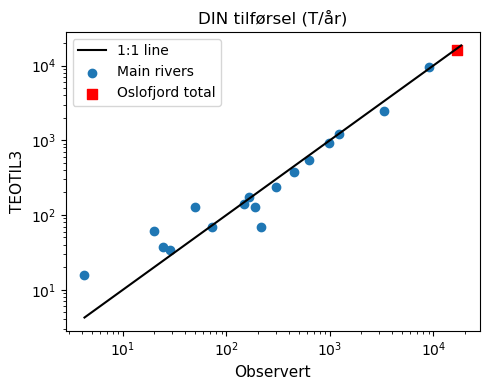

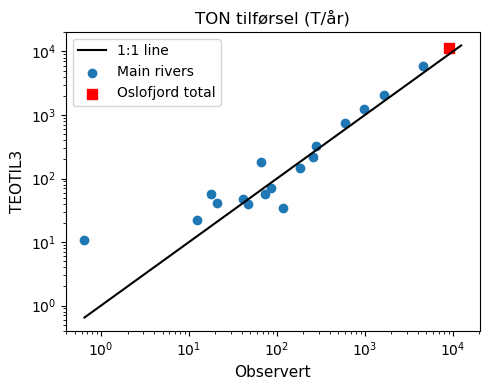

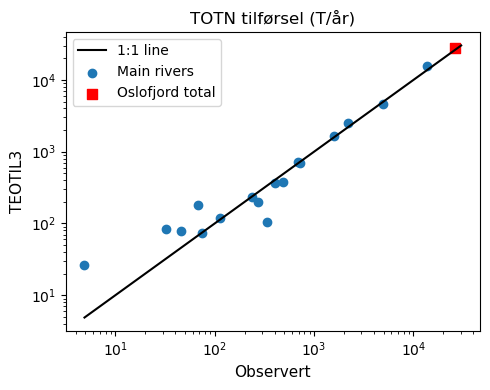

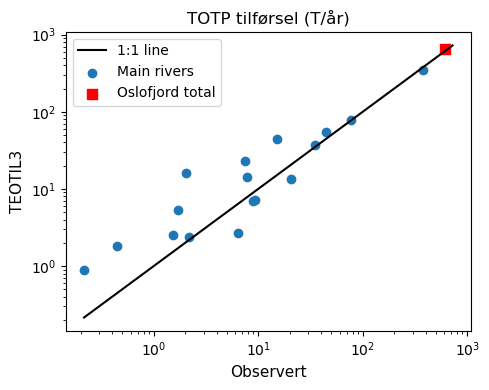

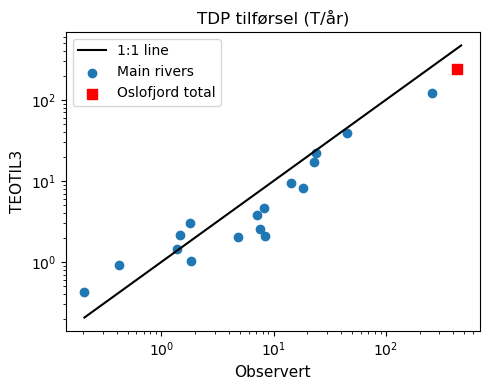

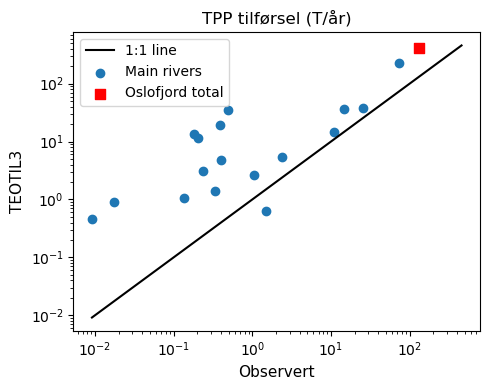

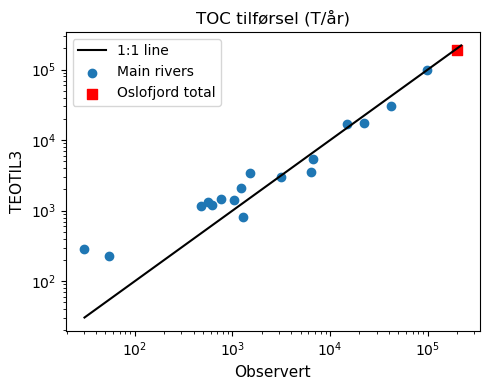

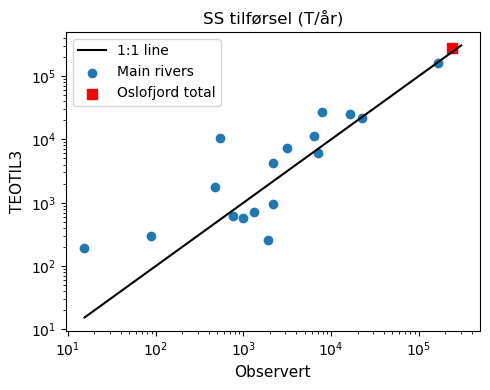

In [66]:
# Plot all vars, one fig per variable

# Dictionary with lowercase as key and uppercase as value
capital_vars_dict = {s: s.upper() for s in t3_vars}

for i, var in enumerate(t3_vars):
    s1 = scaled_of_df[var].copy()
    s2 = t3_df[var].copy()

    # Sum up rivers 15 and 16 to make inputs for just the 1 MCA
    # Don't trust that they're the right way round in the of800 data, the raw data seems to be 
    # too low for Sageneelva (back of envelope, expect more like 30-50 T/yr), and too high in Tofteelva
    s1.loc[16] = s1.loc[[15, 16]].sum()
    s1.drop(15, axis=0, inplace=True)
    s2.loc[16] = s2.loc[[15, 16]].sum()
    s2.drop(15, axis=0, inplace=True)

    # Calculate total for Oslofjord
    total_riv = s1.sum()
    total_teotil = s2.sum()
    load_max = max(total_riv, total_teotil) * 1.1

    plot_df = pd.concat([s1, s2], axis=1)
    plot_df.columns = ["river data", "teotil"]

    # Start plotting

    # Set figure size (width, height in inches)
    fig, ax = plt.subplots(figsize=(5, 4))

    # Add a 1:1 line
    ax.plot(
        [plot_df["river data"].min(), load_max],
        [plot_df["river data"].min(), load_max],
        color="k",
        label="1:1 line"
    )

    # Scatter plot for main rivers
    ax.scatter(plot_df["river data"], plot_df["teotil"], label="Main rivers")

    # Add the OF totals
    ax.scatter(
        total_riv, total_teotil, marker="s", s=50, color="r", label="Oslofjord total"
    )

    # Optional log scales
    ax.set_xscale('log')
    ax.set_yscale('log')

    # ax.grid(True)
    ax.legend()
    ax.set_ylabel("TEOTIL3", size=11)
    ax.set_xlabel("Observert", size=11)
    ax.set_title(f"{capital_vars_dict[var]} tilførsel (T/år)")

    plt.tight_layout()

    # Save or show
    fname = f"teotil_vs_rivdata_annual-loads_{var}_log.png"
    fpath = os.path.join(fig_folder, 't3_vs_of800', fname)
    plt.savefig(fpath)

    plt.show()

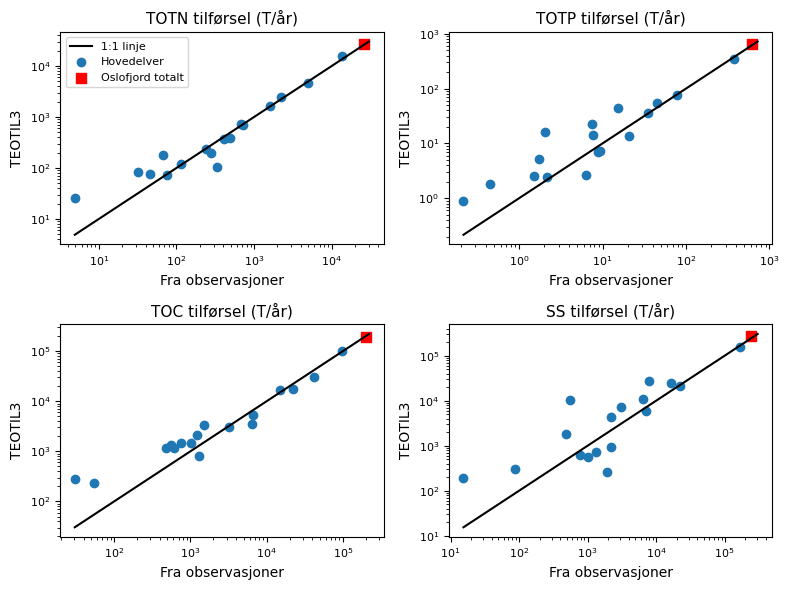

In [76]:
# Choose four variables
selected_vars = ["totn", "totp", "toc", "ss"]

# Create a single figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))  # Adjust size as needed
axes = axes.flatten()  # Flatten to iterate easily

for i, var in enumerate(selected_vars):
    ax = axes[i]

    # Copy data for the variable
    s1 = scaled_of_df[var].copy()
    s2 = t3_df[var].copy()

    # Combine rivers 15 and 16
    s1.loc[16] = s1.loc[[15, 16]].sum()
    s1.drop(15, inplace=True)
    s2.loc[16] = s2.loc[[15, 16]].sum()
    s2.drop(15, inplace=True)

    # Calculate totals
    total_riv = s1.sum()
    total_teotil = s2.sum()
    load_max = max(total_riv, total_teotil) * 1.1

    # Prepare data for plotting
    plot_df = pd.concat([s1, s2], axis=1)
    plot_df.columns = ["river data", "teotil"]

    # Plot 1:1 line
    ax.plot(
        [plot_df["river data"].min(), load_max],
        [plot_df["river data"].min(), load_max],
        color="k",
        label="1:1 linje"
    )

    # Scatter plot
    ax.scatter(plot_df["river data"], plot_df["teotil"], label="Hovedelver")

    # Oslofjord total
    ax.scatter(total_riv, total_teotil, marker="s", s=50, color="r", label="Oslofjord totalt")

    ax.tick_params(axis='both', labelsize=8)

    # Log scales
    ax.set_xscale('log')
    ax.set_yscale('log')

    if i == 0:
        ax.legend(fontsize=8)

    ax.set_xlabel("Fra observasjoner", size=10)
    ax.set_ylabel("TEOTIL3", size=10)
    ax.set_title(f"{capital_vars_dict[var]} tilførsel (T/år)", size=11)

# Adjust layout
plt.tight_layout()

# Save combined figure
fname = "teotil_vs_rivdata_annual-loads_selected_vars_log.png"
fpath = os.path.join(fig_folder, 't3_vs_of800', fname)
plt.savefig(fpath)

plt.show()